# 8. Primera optimización de parámetros

## Importamos paquetes necesarios

In [1]:
import pandas as pd
import numpy as np
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

from skopt import gp_minimize
from skopt.space import Categorical, Dimension, Integer, Real  # noqa

from IPython.display import Image  

import graphviz_tools as agt
import mlflow_utils as a_mlflow_u
import tree_utils as atu

## Cargamos nuestros dataset

In [2]:
file_cervezas_unicas_resumen_valores_con_clase_training = 'dataset/cervezas_unicas_resumen_valores_con_clase_train.csv'
file_cervezas_unicas_resumen_valores_con_clase_testing = 'dataset/cervezas_unicas_resumen_valores_con_clase_test.csv'

campos = ['beer_abv', 'review_aroma', 'review_appearance', 'review_taste', 'review_overall', 'review_palate', 'es_popular']

df_training_validacion = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_training)
df_testing = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_testing)

df_training_validacion = df_training_validacion.loc[:, campos]
df_testing = df_testing.loc[:, campos]

df_training_validacion.head()

,beer_abv,review_aroma,review_appearance,review_taste,review_overall,review_palate,es_popular
0,6.0,3.564000,3.736000,3.592000,3.776000,3.620000,NO
1,4.5,2.608108,3.351351,2.743243,2.945946,3.054054,NO
2,4.4,3.727273,3.727273,3.545455,3.545455,3.545455,NO
3,7.5,3.750000,3.500000,3.750000,3.750000,4.000000,NO
4,7.8,2.500000,3.500000,3.500000,3.500000,3.500000,NO


In [3]:
random_state = 1
test_size = 0.3

atributos = ['beer_abv', 'review_aroma', 'review_appearance', 'review_taste', 'review_overall', 'review_palate']
clase = ['es_popular']

Y_df_training_validacion = df_training_validacion.loc[:, clase]
df_training_validacion = df_training_validacion.loc[:, atributos]

### Tambien abrimos en X e Y el dataset de testing

In [4]:
X_testing = df_testing.loc[:, atributos]
Y_testing = df_testing.loc[:, clase]

## Optimización del modelo

# <span style="color:RED"> EXPLICAR CROSS VALIDATION </span>

In [5]:
def cv_con_umbral_de_corte(params):
    umbral_corte = params[0]
    max_depth = params[1]
    X = df_training_validacion
    y = Y_df_training_validacion
    #criterion='entropy'
    criterion='gini'
    #criterion='log_loss'
    clf = DecisionTreeClassifier(
                criterion = criterion,
                max_depth=max_depth,
                random_state=1
            )

    # 5-fold cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    def all_metrics(clf, X, y):
        y_pred = clf.predict_proba(X)
        df_y_pred_proba = pd.DataFrame(y_pred, columns = ['NO_prob', 'SI_prob'])
        
        y_pred = atu.evaluar_corte(df_y_pred_proba['NO_prob'].values, umbral_corte, 'SI', 'NO')

        metricas = atu.calcular_metricas(
            y_true = y['es_popular'].values, 
            y_pred = y_pred, 
            labels=['NO', 'SI']
        )

        return metricas

    scores = cross_validate(clf, X, y, scoring=all_metrics, cv=cv)

    resultados = {
        'true negatives':          round(np.mean(scores['test_true negatives']), 2),
        'true positives':          round(np.mean(scores['test_true positives']),2),
        'false positives':         round(np.mean(scores['test_false positives']),2),
        'false negatives':         round(np.mean(scores['test_false negatives']),2),
        'accuracy':                round(np.mean(scores['test_accuracy']),2),
        'recall':                  round(np.mean(scores['test_recall']),2),
        'precision':               round(np.mean(scores['test_precision']),2),
        'specificity':             round(np.mean(scores['test_specificity']),2),
        'tasa falso positivo':     round(np.mean(scores['test_tasa falso positivo']),2),
        'tasa falso negativo':     round(np.mean(scores['test_tasa falso negativo']),2),
        'f1':                      round(np.mean(scores['test_f1']),2),
        'metrica negocio':         round(np.mean(scores['test_metrica negocio']),2),
        'metrica optima negocio':  round(np.mean(scores['test_metrica optima negocio']),2)
    }
    return -resultados['metrica negocio']

resultados = cv_con_umbral_de_corte([0.95, 4])
-resultados

1963.86

In [6]:
import warnings
warnings.filterwarnings('ignore')

space  = [
    Real(0.00001, 0.99999, name='umbral_corte'),
    Integer(3, 6, name = 'max_depth')
]

res = gp_minimize(cv_con_umbral_de_corte,                  # the function to minimize
                  space,     # the bounds on each dimension of x
                  n_initial_points = 10,
                  n_calls=50,         # the number of evaluations of f including at x0
                  n_random_starts=10,  # the number of random initialization points
                  random_state=777,
                  callback = lambda res: print([len(res.func_vals), -res.fun])
                 )

[1, 20.04]
[2, 20.04]
[3, 40.79]
[4, 327.42]
[5, 327.42]
[6, 327.42]
[7, 327.42]
[8, 1940.79]
[9, 2118.96]
[10, 2118.96]
[11, 2118.96]
[12, 2314.02]
[13, 2314.02]
[14, 2323.91]
[15, 2324.71]
[16, 2324.71]
[17, 2324.71]
[18, 2324.71]
[19, 2324.71]
[20, 2324.71]
[21, 2324.71]
[22, 2324.71]
[23, 2324.71]
[24, 2324.71]
[25, 2324.71]
[26, 2324.71]
[27, 2324.71]
[28, 2324.71]
[29, 2324.71]
[30, 2324.71]
[31, 2324.71]
[32, 2324.71]
[33, 2324.71]
[34, 2324.71]
[35, 2324.71]
[36, 2324.71]
[37, 2324.71]
[38, 2324.71]
[39, 2324.71]
[40, 2324.71]
[41, 2324.71]
[42, 2324.71]
[43, 2324.71]
[44, 2324.71]
[45, 2324.71]
[46, 2324.71]
[47, 2324.71]
[48, 2324.71]
[49, 2324.71]
[50, 2324.71]


In [7]:
[res.x, -res.fun]

[[0.9332460409294779, 6], 2324.71]

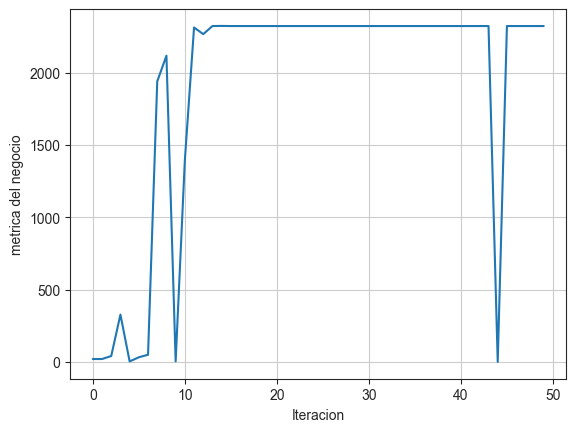

In [8]:
sns.set_style("ticks",{'axes.grid' : True})

chart_df = pd.DataFrame(data = -res.func_vals, columns=['y'])
chart_df.reset_index(inplace=True)
chart_df.columns = ['iteracion', 'metrica negocio']
g1 = sns.lineplot(data=chart_df, x="iteracion", y="metrica negocio")
g1.set(xlabel='Iteracion', ylabel='metrica del negocio')
plt.show()

### Utilizamos estos parámetros para crear un nuevo modelo

In [9]:
umbral_de_corte = res.x[0]
max_depth = res.x[1]
#criterion='entropy'
criterion='gini'
#criterion='log_loss'

clf = DecisionTreeClassifier(
            criterion = criterion,
            max_depth=max_depth,
            random_state=1
        )
_ = clf.fit(df_training_validacion, Y_df_training_validacion)


### Probamos los nuevos parámetros en validación

In [10]:
Y_testing_pred = clf.predict_proba(X_testing)

df_y_testing_pred_proba = pd.DataFrame(Y_testing_pred, columns = ['NO_prob', 'SI_prob'])
Y_testing_pred = atu.evaluar_corte(df_y_testing_pred_proba['NO_prob'].values, umbral_de_corte, 'SI', 'NO')

metricas = atu.calcular_metricas(
    y_true = Y_testing['es_popular'].values, 
    y_pred = Y_testing_pred, 
    labels=['NO', 'SI']
)

parametros = {
    'max_depth': max_depth,
    'umbral_corte': umbral_de_corte
}
   
[metricas, parametros]

[{'true negatives': 10592,
  'true positives': 594,
  'false positives': 3374,
  'false negatives': 144,
  'accuracy': 0.7607,
  'recall': 0.8049,
  'precision': 0.1497,
  'specificity': 0.7584,
  'tasa falso positivo': 0.2416,
  'tasa falso negativo': 0.0103,
  'f1': 0.2524,
  'metrica negocio': 2305.149051490515,
  'metrica optima negocio': 4000.0},
 {'max_depth': 6, 'umbral_corte': 0.9332460409294779}]

In [11]:
a_mlflow_u.log_experimento(
    host = 'http://localhost:5000', 
    nombre_experimento="AnalisisDeCervezas", 
    run_name="Cuarta ejecucion", 
    descripcion="Rpart optimización gausiana CV + umbral_corte + max_depth ", 
    dataset_tag="validacion", 
    parametros=parametros, 
    metricas=metricas,
    model=clf, 
    artifact_path="model"
)